# Linear regression

## The Boston Housing Dataset

In the previous exercise, we found that the output variable MEDV is linearly dependent on the input variables LSTAT and RM.

* RM - average number of rooms per apartment (input variable)
* LSTAT - the percentage of the population that is lower (input variable)
* MDEV - median value of owner-occupied dwellings in $1,000 (output variable)

## Objective
The objective of this exercise is to develop a linear model that estimates the MDEV (house price) based on the input values of RM (number of rooms) and LSTAT (population).

## Data preparation

### Data loading

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

In [2]:
data = pd.read_csv ("..\\dataset\\HousingData.csv")

### Data cleaning

Remove records with NULL values.

In [3]:
data=data.dropna()

Removing outliers from house prices. For houses in the higher price level, the resulting linear model would not work well (experimentally verified). For these houses it would be appropriate to create your own model.

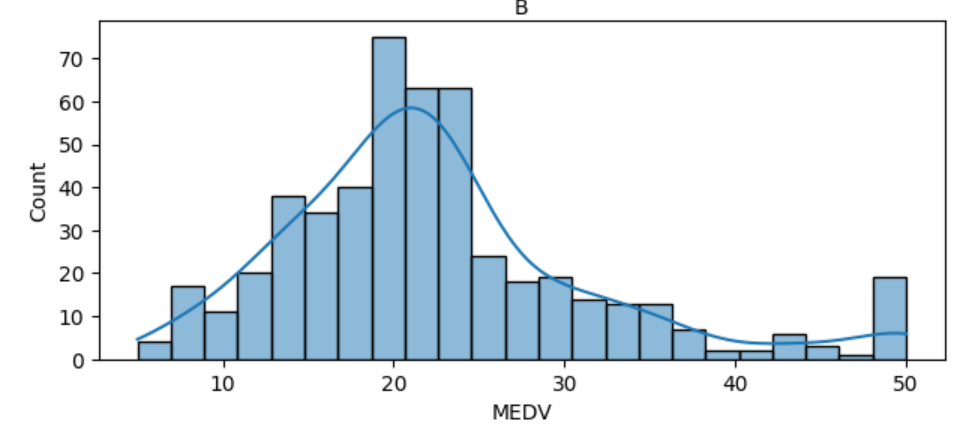

In [4]:
data = data[~(data['MEDV'] >= 40.0)]

## Linear model with one variable

To illustrate, we first create a model that predicts the MEDV from a single input variable RM.

### Converting values from pandas to numpy arrays

In [5]:
import numpy as np

We split the data into input parameters X and results Y.

In [6]:
X = pd.DataFrame(np.c_[data['RM']], columns = ['RM'])
Y = data['MEDV']

In [7]:
X.describe()

,RM
count,371.000000
mean,6.189722
std,0.592102
min,3.561000
25%,5.870500
50%,6.164000
75%,6.512000
max,8.780000


In [8]:
Y.describe()

count    371.000000
mean      20.818868
std        6.883723
min        5.000000
25%       16.400000
50%       20.600000
75%       24.250000
max       39.800000
Name: MEDV, dtype: float64

### Splitting the dataset into training, testing and validation subsets

For learning, we will use the scikit-learn library with algorithms for learning with and without a teacher.

Alternatively, you can install the library using the command: **pip install scikit-learn**

In [10]:
from sklearn.model_selection import train_test_split

train_test_split splits the data set into only 2 parts.

Let's create a function that splits the data into 3 parts - training, validation and test data

In [11]:
def split_dataset (X, Y, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10):
    """ Slitting the dataset into training, validation and testing subset
        X - explanatory variables
        Y - explained variables

        train_ratio      - training data ratio
        validation_ratio - validation data ratio
        test_ratio       - ratio of test data

    """
    assert(train_ratio + validation_ratio + test_ratio == 1.0)

    # train now makes up 75% of the entire data set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)

    # test is now 10% of the original data set
    # is now 15% of the original data set
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

We split the dataset and check the size of each part.

In [12]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)
print (X_train.shape, Y_train.shape)
print (X_val.shape, Y_val.shape)
print (X_test.shape, Y_test.shape)

(278, 1) (278,)
(55, 1) (55,)
(38, 1) (38,)


### Manual linear regression
Before we show the automatic functions that create the linear model in a moment, let's try to create the model manually and step through the steps.

This will give you an indication of the learning principle of most AI models.

At the beginning of the learning process, the parameters need to be initialized with random hotnotes.

In [13]:
import random
def initialize(dim):
    """ Initial linear model parameter settings - bias and weights
    """
    bias=random.random()
    weights=np.random.rand(dim)
    return bias, weights

In [14]:
def print_model_params(bias, weights):
    """Printing the current model parameters
    """
    print ("Model parameters\n================")
    print(f"Bias: {bias}")
    print (f"Weights: {weights}")  

In [15]:
bias, weights=initialize(X.shape[1])
print_model_params(bias, weights)

Model parameters
Bias: 0.27920308162036944
Weights: [0.97811778]


We create a function that predicts the output value Y for the input values X and the model parameters.

The matrix multiplication function from the numpy library is used for speedup.

In [16]:
def predict(X, bias, weights):
    """ Based on the model parameters (bias and weights), the function calculates the output values Y from the input values X
        X - input numpy matrix
        bias - model parameter b
        weights - array of weights

        Returns matrix of predicted values Y
    """
    return bias + np.dot(X, weights)

We test how the random parameter model predicts the output values for the training data.

In [17]:
print ("Predicted values\n================")
Y_predicted = predict(X_train, bias, weights)
Y_predicted[0:10]

Predicted values


array([6.43841072, 6.91279784, 5.85545252, 6.85900136, 6.54111309,
       6.51666014, 6.76412394, 5.69406309, 7.27078895, 6.63207804])

We plot the training data and the linear model on the same graph. 

In [18]:
def visualize_model_2d (X, Y, Y_predicted):
    """ Visualization of simple linear model in 2D
        X - real input data
        Y - real output data
        Y_predicted - predicted output data
    """
    plt.figure() 
    plt.plot (X, Y_predicted, c='b', label = "Train prediction")
    plt.scatter (X, Y, marker = 'x', c='r', label="Train actual")
    plt.title ("Model")
    plt.ylabel("$")
    plt.xlabel("RM")
    plt.legend()
    plt.show()

For random parameters, the model is not very good at predicting values.

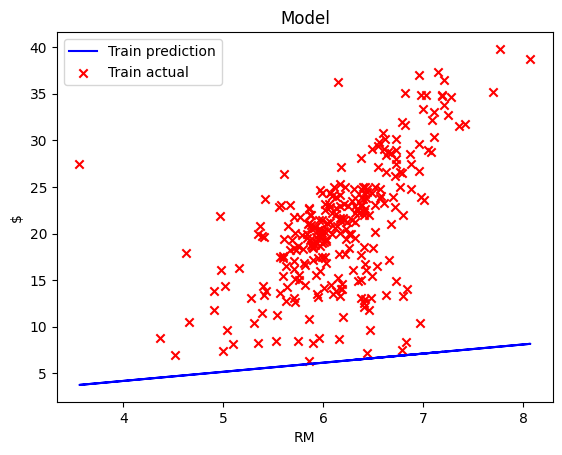

In [19]:
visualize_model_2d(X_train, Y_train, Y_predicted)

### Cost function

How much the model prediction differs from the actual values is told by the cost function. There are several cost functions, for linear regression we will use MSE (Mean square error).

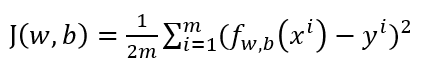

In [20]:
def get_cost(Y, Y_predicted):
    """ Return MSE for real and predicted ouput data
    """
    Y_resd = Y - Y_predicted
    return np.sum(np.dot(Y_resd.T,Y_resd))/(len(Y-Y_resd)*2)

In [21]:
def print_cost (Y_train, Y_predicted):
    print (f"Cost function MSE: {get_cost(Y_train, Y_predicted)}")

A model with random parameters will have a very high cost function value.

In [22]:
print_cost(Y_train, Y_predicted)

Cost function MSE: 124.46797526044166


### Evaluation of the model
To evaluate the model we use: 
- R2 function (R-squared, coefficient of determination, regression score function). The value for a model that predicts the data without error is 1.0. A higher value is better.
- RMSE (root mean square error). A smaller value is better

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
def print_model_score(Y_train, Y_predicted):
    """ Printing model score
    """
    r2 = r2_score(Y_train, Y_predicted)
    rmse = (np.sqrt(mean_squared_error(Y_train, Y_predicted)))    
    print('R2 score: {}'.format(r2))    
    print('RMSE: {}'.format(rmse))

In [25]:
print_model_score (Y_train, Y_predicted)

R2 score: -4.6062117500284
RMSE: 15.777704222125704


### One iteration of learning
The model parameters are set to random values. In this section we will perform one iteration of learning. 

After it is completed, the model score should be better.

To improve the model parameters, we need to calculate the partial derivative to determine the direction of parameter shift. The magnitude of the parameter change is corrected through the learning rate. The details are explained in the lecture.

In [26]:
def update_weights(X, Y, Y_predicted, bias_0, weights_0, learning_rate):
    """ The function adjusts the model parameters bias and weights

        X - input values
        Y - correct output values
        Y_predicted - predicted values
        bias_0 - current value of bias
        weights_0 - current values of weights
        learning_rate - learning rate alpha

    """

    # calculation of partial derivatives
    delta_bias = (np.sum(Y_predicted - Y))/len(Y)
    delta_weights = (np.dot((Y_predicted - Y),X))/len(Y)

    # calculation of model parameter adjustments
    bias_1 = bias_0 - learning_rate * delta_bias
    weights_1 = weights_0 - learning_rate * delta_weights
    return bias_1, weights_1

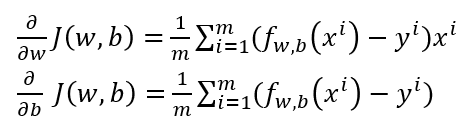

In [27]:
Y_predicted = predict(X_train, bias, weights)
bias, weights = update_weights(X_train, Y_train, Y_predicted, bias, weights, 0.01)
print_model_params(bias, weights)

Model parameters
Bias: 0.42369030895161475
Weights: [1.88881004]


Compare the cost function value, graph and score with the previous ones.

In [28]:
Y_predicted = predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)

Cost function MSE: 56.16349566325391


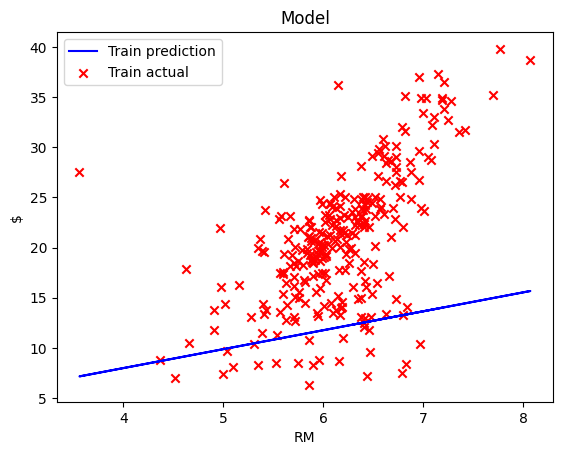

In [29]:
visualize_model_2d(X_train, Y_train, Y_predicted)

In [30]:
print_model_score (Y_train, Y_predicted)

R2 score: -1.5296824235404216
RMSE: 10.598442872729363


### All learning
In the previous section, we have shown only one iteration of learning. Now we will create a function that will perform each iteration in a loop.

In [31]:
def run_gradient_descent(X, Y, learning_rate, num_iterations):
    """ Algoritmus gradient descent 
        X - input data
        Y - output data
        learning_rate - learning rate alpha
        num_iteration - number of iteration    

        gd_iterations_df - history of learning
        bias             - bias parameter
        weights          - weights parameter
    """
    # initialization of model parameters
    bias, weights=initialize(X.shape[1])
    iter_num=0

    # saving the learning progress to the dataFrame
    gd_iterations_df=pd.DataFrame(columns=['iteration','cost'])
    result_idx=0
    
    for each_iter in range(num_iterations):
        # control score display
        Y_predicted = predict(X, bias, weights)
        this_cost=get_cost(Y, Y_predicted)

        # parameter improvements
        prev_bias=bias
        prev_weights=weights
        bias, weights = update_weights(X, Y, Y_predicted, prev_bias, prev_weights, learning_rate)

        # saving every 10th iteration to the learning history
        if(iter_num % 10==0):
            gd_iterations_df.loc[result_idx]=[iter_num, this_cost]
            result_idx=result_idx+1

        iter_num +=1    
    return gd_iterations_df, bias, weights

In [32]:
gd_iterations_df, bias, weights=run_gradient_descent(X_train, Y_train, learning_rate=0.001, num_iterations=200)

The resulting model is displayed and can be compared with the first iteration.

In [33]:
print_model_params(bias, weights)
Y_predicted=predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Model parameters
Bias: 0.8253803144073673
Weights: [3.26401953]
Cost function MSE: 16.40899247607746
R2 score: 0.2609160209039725
RMSE: 5.72869836456371


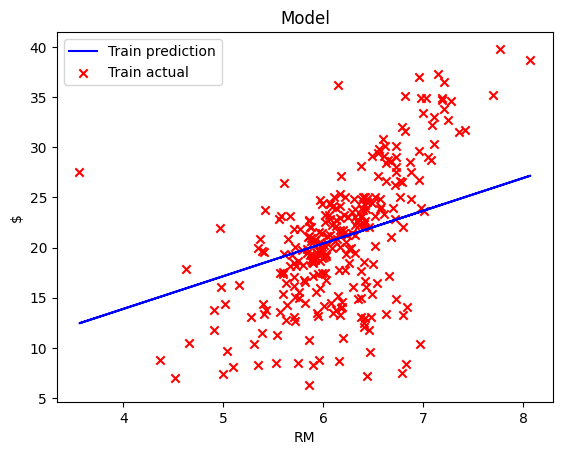

In [34]:
visualize_model_2d(X_train, Y_train, Y_predicted)

### Model validation
During the learning process, we adjusted the parameters of the model to fit the training data as closely as possible.

Now we need to verify that the model will work correctly on data that it has not yet seen (X_val).

In [35]:
Y_val_predicted = predict(X_val, bias, weights)
print_cost(Y_val, Y_val_predicted)
print_model_score(Y_val, Y_val_predicted)

Cost function MSE: 13.368091197542283
R2 score: 0.32077955622985854
RMSE: 5.17070424556313


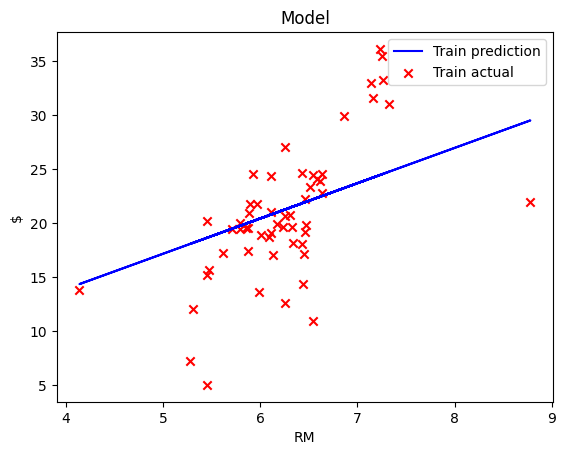

In [36]:
visualize_model_2d(X_val, Y_val, Y_val_predicted)

### The learning process
We can see if the learning process went well from the graph that shows us the evolution of the cost function over the iterations.

If the learning process is working properly, the cost function should be decreasing.

Text(0, 0.5, 'Cost or MSE')

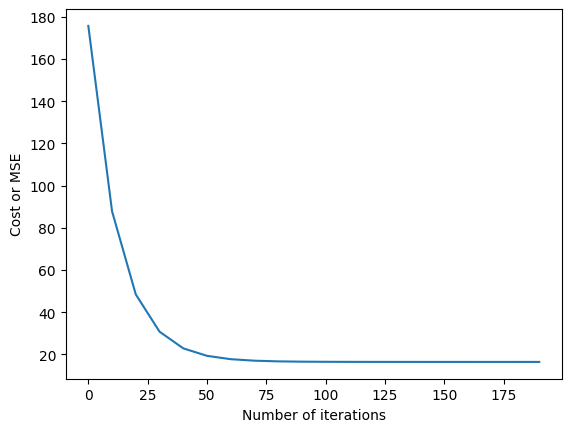

In [37]:
plt.plot(gd_iterations_df['iteration'], gd_iterations_df['cost'])
plt.xlabel("Number of iterations")
plt.ylabel("Cost or MSE")

### Speed of learning
The learning rate is determined by the learning_rate value. That is, a number that determines the size of changes in the model parameters.

With a higher learning rate, the model will learn faster, but there is a risk that the learning process will not work. (see lecture)

We will illustrate the effect of learning rate with two learning history graphs. 

In [38]:
alpha_df_1, bias_1, weights_1=run_gradient_descent(X_train, Y_train, learning_rate=0.01, num_iterations=200)
alpha_df_2, bias_2, weights_2=run_gradient_descent(X_train, Y_train, learning_rate=0.001, num_iterations=200)

The resulting models are almost identical.

Model parameters
Bias: 0.8444524281755537
Weights: [3.26189568]
Cost function MSE: 16.412758051982895


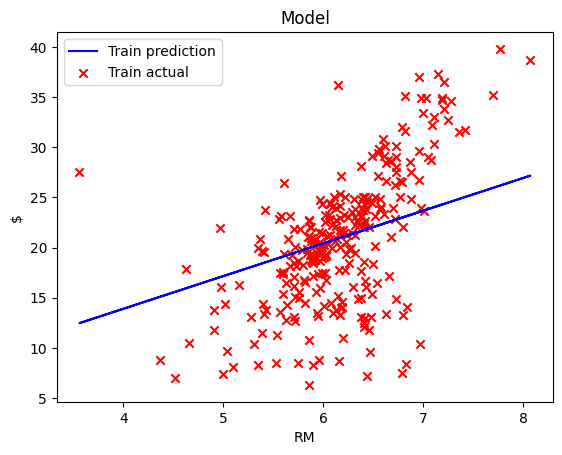

In [39]:
print_model_params(bias_1, weights_1)
Y_predicted_1 = predict(X_train, bias_1, weights_1)
print_cost(Y_train, Y_predicted_1)
visualize_model_2d(X_train, Y_train, Y_predicted_1)

Model parameters
Bias: 0.827593502445828
Weights: [3.2636666]
Cost function MSE: 16.409434491182758


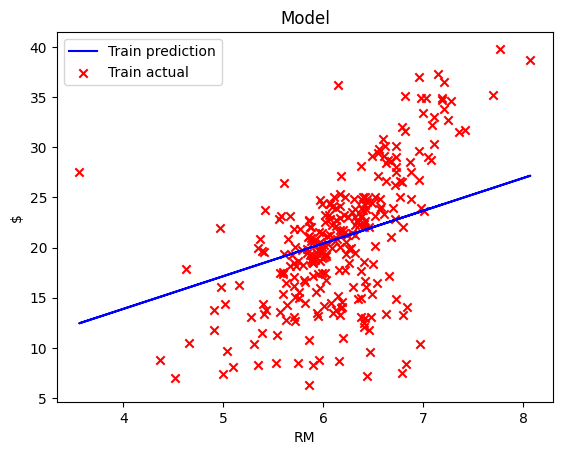

In [40]:
print_model_params(bias_2, weights_2)
Y_predicted_2 = predict(X_train, bias_2, weights_2)
print_cost(Y_train, Y_predicted_2)
visualize_model_2d(X_train, Y_train, Y_predicted_2)

At a higher learning rate, the value of the cost function decreases faster.

Text(0.5, 1.0, 'Cost vs. Iterations for different alpha values')

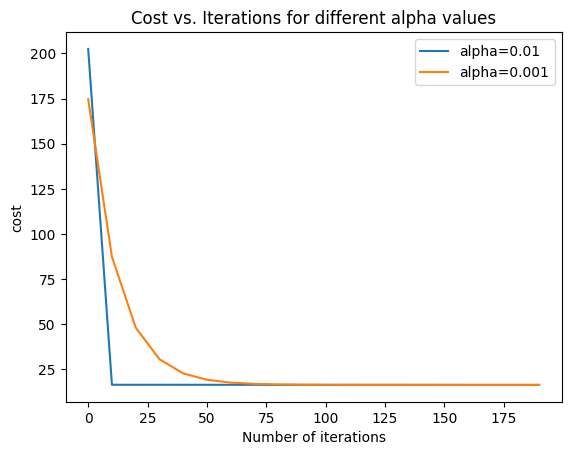

In [41]:
# model training speed for different learning rate alpha
plt.plot(alpha_df_1['iteration'],alpha_df_1['cost'],label="alpha=0.01")
plt.plot(alpha_df_2['iteration'],alpha_df_2['cost'],label="alpha=0.001")
plt.legend()
plt.ylabel('cost')
plt.xlabel('Number of iterations')
plt.title('Cost vs. Iterations for different alpha values')

## Linear model with multiple variables

Now we create a model with two parameters RM and LSTAT.

### Data preparation

In [42]:
X = pd.DataFrame(np.c_[data['RM'],data['LSTAT']], columns = ['RM', 'LSTAT']).to_numpy()
Y = data['MEDV'].to_numpy()

Subdataset size control

In [43]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)
print(X_train.shape, Y_train.shape)
print (X_val.shape, Y_val.shape)
print (X_test.shape, Y_test.shape)

(278, 2) (278,)
(55, 2) (55,)
(38, 2) (38,)


One record from the training data.

In [44]:
print (X_train[0, :])
print (Y_train[0])

[6.782 6.68 ]
32.0


### Data visualization in 3D
Because we have two input variables and one output variable. The data is best displayed in a 3D graph.

In [45]:
x_label, y_label, z_label = "Living Area (m²)", "Bedrooms", "Price"
X1 = X_train[:, 0]  # 1st column
X2 = X_train[:, 1]  # 2nd column
Y = Y_train  # Target variable
    
# Creating a 3D scatter fence
fig = go.Figure(layout=go.Layout(width=1000, height=1000))

fig.add_trace(go.Scatter3d(
        x=X1, y=X2, z=Y,
        mode='markers',
        marker=dict(size=5, color=Y, colorscale='Viridis', opacity=0.8),
        name="Data"
))
fig.show()

### Model initialization
Initialize the parameters and then run the first iteration.

Since we have written the necessary functions using numpy arrays, we can use them unchanged.

We display the model parameters, predicted values, cost function value and model evaluation.

In [46]:
bias, weights=initialize(X.shape[1])
print_model_params(bias, weights)

Model parameters
Bias: 0.10906988507853088
Weights: [0.98764029 0.12597846]


In [47]:
Y_predicted=predict(X_train, bias, weights)
Y_predicted[0:10]

array([ 7.64878247,  7.06256363,  8.2458158 ,  9.4469777 , 10.1232219 ,
        8.25203674,  9.11097082,  9.34835361,  7.76707855,  8.69212706])

In [48]:
print_cost(Y_train, Y_predicted)

Cost function MSE: 109.29391415685252


In [49]:
# initial model score
print_model_score (Y_train, Y_predicted)

R2 score: -3.6157035461086773
RMSE: 14.784716037641882


Since we have two input variables, the resulting linear model will have the shape of a plane in space.

Therefore, we will use a 3D graph to represent it.

In [50]:
def visualize_model_3D(X1, X2, Y, bias, weights, points=50):      
    # Descriptions of axis
    x_label, y_label, z_label = "Living Area (m²)", "Bedrooms", "Price"
    
    # Creating a 3D scatter plot
    fig = go.Figure(layout=go.Layout(width=1000, height=1000))

    # Scatter plot - data
    fig.add_trace(go.Scatter3d(
        x=X1, y=X2, z=Y,
        mode='markers',
        marker=dict(size=5, color=Y, colorscale='Viridis', opacity=0.8),
        name="Data"
    ))

    # Model curve
    x_range = np.linspace(min(X1), max(X1), points)
    y_range = np.linspace(min(X2), max(X2), points)
    xs, ys = np.meshgrid(x_range, y_range)
    zs = xs * weights[0] + ys * weights[1] + bias 

    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs,
        colorscale="Blues",
        opacity=0.5,
        name="Model Surface"
    ))

    fig.update_layout(
        title="3D Model Visualization",
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label
        )
    )

    # Chart display
    fig.show()

In [51]:
visualize_model_3D (X1, X2, Y_train, bias, weights, 30)

## First iteration of iteration

In [52]:
bias, weights = update_weights(X_train, Y_train, Y_predicted, bias, weights, 0.01)

In [53]:
print_model_params(bias, weights)

Model parameters
Bias: 0.23785732146212332
Weights: [1.81167044 1.40907042]


In [54]:
Y_predicted=predict(X_train, bias, weights, )
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Cost function MSE: 165.0589746948456
R2 score: -5.97077509478412
RMSE: 18.169148284652508


In [55]:
visualize_model_3D (X1, X2, Y_train, bias, weights, 30)

### All learning

In [56]:
gd_iterations_df, bias, weights=run_gradient_descent(X_train,Y_train, learning_rate=0.001, num_iterations=500)

In [57]:
print_model_params(bias, weights)

Model parameters
Bias: 1.4125673171688036
Weights: [ 4.22961734 -0.51906544]


In [58]:
Y_predicted=predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Cost function MSE: 8.29157421519789
R2 score: 0.6498300129228867
RMSE: 4.072241204839883


In [59]:
visualize_model_3D(X1, X2, Y_train, bias, weights, 40)

### Model validation

In [60]:
Y_val_predicted = predict(X_val, bias, weights, )
print_cost(Y_val, Y_val_predicted)
print_model_score (Y_val, Y_val_predicted)

Cost function MSE: 11.518970474066794
R2 score: 0.5499857655290671
RMSE: 4.799785510638323


### The learning process

Text(0, 0.5, 'Cost or MSE')

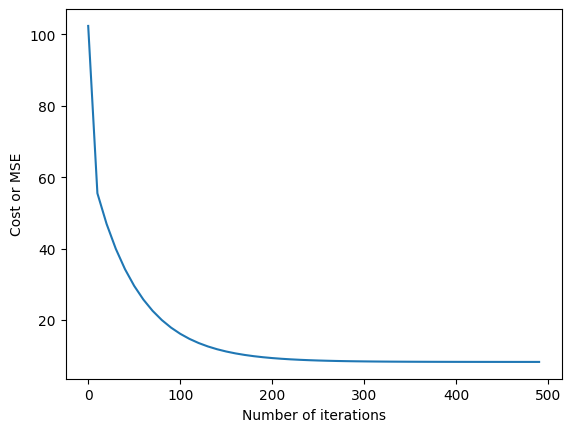

In [61]:
fig2=plt.figure()
plt.plot(gd_iterations_df['iteration'], gd_iterations_df['cost'])
plt.xlabel("Number of iterations")
plt.ylabel("Cost or MSE")

## Linear model from scikit-sklearn
So far, we have done all the programming manually. This was in order to show the gradual learning process.

Of course there are libraries for creating linear and other models. For example, scikit-sklearn.

We will now demonstrate the same task using this library.

### Training the model

In [62]:
from sklearn.linear_model import LinearRegression

Creating a linear model

In [63]:
lin_model = LinearRegression()

Training the model on training data. We fit the data to the model.

In [64]:
lin_model.fit(X_train, Y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Printing model parameters

In [65]:
print ("Bias: ", lin_model.intercept_)
print("Weights: ", lin_model.coef_)

Bias:  11.351537201952375
Weights:  [ 2.83179186 -0.60912218]


Predicting output values from training data

In [66]:
Y_predicted = lin_model.predict(X_train)

Score and model display

In [67]:
print_model_score(Y_train, Y_predicted)

R2 score: 0.6588603144838008
RMSE: 4.019390079802446


In [68]:
visualize_model_3D(X1, X2, Y_train, lin_model.intercept_, lin_model.coef_, 40)

### Model validation
We test the model on validation data.

In [69]:
Y_val_predict = lin_model.predict(X_val)

In [70]:
print_model_score(Y_val, Y_val_predict)

R2 score: 0.5826863388858421
RMSE: 4.622107114041162


### Save model to file
The trained model can be saved for later use. 

For example, we write a web application where the user enters the number of rooms and the population status and the model returns an estimate of the price of the apartment.

Note that the model will only be valid for Boston in 1978.

In [71]:
import pickle
filename = 'regression_linear_model.sav'
pickle.dump(lin_model, open(filename, 'wb'))

We would load the model in the program using the following example.

In [72]:
loaded_model = pickle.load(open(filename, 'rb'))

And we would use it. We save the input values in an array and then run the predict function.

In [73]:
x=[[5.87, 14.37]]
Y_predicted = loaded_model.predict(x)
print (f"The estimated price of the property is {Y_predicted[0]}")

The estimated price of the property is 19.22106969689346
